In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *

In [3]:
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}

In [4]:
imgs_path = "../src/imgs"

# Helper functions

In [5]:
def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        

        dataframe["computation_times_final"] = [dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]


def combine_datasets(algorithm_name, log_data_path):
    simulations = []
    for dataset_name in ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1", "UK75_3", "UK75_6"]:
        simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
        if dataset_name == "UK25_2":
            simulation = remove_unwanted_mutation_parameter_groups(simulation)
            if algorithm_name == "SA":
                simulation["Parameter Group"] = simulation["Parameter Group"]/2
            else:
                simulation["Parameter Group"] = sorted(list(range(45)) * 30)
        simulations.append(simulation)
    
    for df in simulations:
        add_final_fitness_columns(df)
        expand_parameter_colums(df)
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)

    return pd.concat(simulations)


def plot_3d_minmax(datapoints, labels, marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    
    plt.style.use("../src/style/custom-seaborn-3dplot.mplstyle")
    fig,ax = plt.subplots(1,1,subplot_kw={"projection": "3d"})
    for data, label in zip(datapoints, labels):

        #fuel_consumptions = np.array(data.fuel_consumption_final)#np.array( [x[0] for x in data.fitness_final])
        #drive_times = data.vehicle_route_time
        #compute_times = np.array(data.optimal_time)
        
        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
        mean_f1,min_f1,max_f1 =  data.longest_route_time_final_mean, data.longest_route_time_final_min, data.longest_route_time_final_max
        mean_f2,min_f2,max_f2 =  data.computation_times_final_mean, data.computation_times_final_min, data.computation_times_final_max
        
        #print(mean_f1,min_f1,max_f1)
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k")
        plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        
        ax.scatter(xs= mean_f0, ys=mean_f1, zs=mean_f2, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        # ax.scatter(xs= mean_f0,ys=mean_f1,zs=mean_f2,label=plotlabel,s=200,marker=marker,zorder=2,color=sns.color_palette("deep",10)[1])
    return fig, ax


# SA

In [6]:
SA_data = combine_datasets("SA", "parameter_data/")

In [7]:
SA_best = SA_data.groupby("Parameter Group").mean().iloc[4]

In [9]:
SA_data

,Unnamed: 0,fitness,route_distance,fuel_consumption,vehicle_loads,computation_times,vehicle_route_time,violation,paths,Parameter Group,...,longest_route_time_final_max,longest_route_time_final_minmax,computation_times_final_mean,computation_times_final_min,computation_times_final_max,computation_times_final_minmax,distance_to_origin_mean,distance_to_origin_min,distance_to_origin_max,distance_to_origin_minmax
0,0.0,"[393.5102749755074, 393.5102749755074, 393.510...","[124524, 113277, 137591, 125813, 82874]","[77.47694164217408, 77.47694164217408, 77.4769...","[array([ 0., 766., 649., 478., 227.]), array(...","[0.0069119930267333984, 0.014105081558227539, ...","[8730, 8539, 7993, 7512, 6674]","[-98.0, -98.0, -98.0, -98.0, -98.0, -98.0, -98...","[['V0', 14, 9, 13, 23, 22], ['V3', 18, 3, 1, 2...",0.0,...,145.529899,0.233006,3.501308,3.447100,3.555516,0.795364,168.392495,166.544373,170.240618,0.219742
1,1.0,"[393.5102749755074, 346.4884166681708, 346.488...","[117875, 120045, 135302, 108251, 100945]","[77.47694164217408, 99.03841666817084, 99.0384...","[array([ 0., 766., 649., 816., 227.]), array(...","[0.008916854858398438, 0.018409252166748047, 0...","[8103, 8120, 7792, 7815, 8205]","[-98.0, -22.0, -22.0, -22.0, -22.0, -22.0, -22...","[['V0', 14, 9, 7, 23, 22], ['V5', 24, 21, 1, 2...",0.0,...,145.529899,0.145754,3.501308,3.447100,3.555516,0.610233,168.392495,166.544373,170.240618,0.121843
2,2.0,"[393.5102749755074, 393.5102749755074, 380.641...","[112969, 138042, 37131, 112220, 75310, 98083]","[77.47694164217408, 77.47694164217408, 96.6417...","[array([ 0., 766., 649., 478., 816.]), array(...","[0.00734400749206543, 0.015714645385742188, 0....","[7855, 8748, 3402, 6939, 6042, 7892]","[-98.0, -98.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V0', 14, 9, 13, 7, 20], ['V1', 19, 23, 22],...",0.0,...,145.529899,0.235998,3.501308,3.447100,3.555516,0.853839,168.392495,166.544373,170.240618,0.211927
3,3.0,"[393.5102749755074, 393.5102749755074, 303.284...","[122371, 75113, 124504, 114509, 57028, 82874]","[77.47694164217408, 77.47694164217408, 88.6349...","[array([ 0., 766., 649., 478., 816., 227.]), ...","[0.006919145584106445, 0.014350414276123047, 0...","[9095, 5796, 7328, 7140, 4838, 6674]","[-98.0, -98.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V1', 14, 9, 13, 7, 23, 22], ['V3', 18, 24, ...",0.0,...,145.529899,0.293668,3.501308,3.447100,3.555516,0.884525,168.392495,166.544373,170.240618,0.269557
4,4.0,"[296.1352315545324, 296.1352315545324, 296.135...","[117587, 129000, 58219, 128252, 19871, 98814]","[78.10189822119911, 78.10189822119911, 78.1018...","[array([ 0., 649., 766., 816., 227.]), array(...","[0.009275674819946289, 0.020374536514282227, 0...","[8174, 8339, 4480, 8471, 1972, 8206]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[['V0', 9, 14, 7, 23, 22], ['V1', 13, 19, 20],...",0.0,...,145.529899,0.189962,3.501308,3.447100,3.555516,0.634426,168.392495,166.544373,170.240618,0.132716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,25.0,"[3126.22048103201, 3126.22048103201, 3126.2204...","[100752, 95547, 87654, 187588, 226770, 174107,...","[340.6538143653435, 340.6538143653435, 340.653...","[array([662., 577., 788., 761.]), array([184.,...","[0.016869068145751953, 0.03346848487854004, 0....","[8191, 5978, 5566, 14619, 15688, 16347, 6196, ...","[-2278.0, -2278.0, -2278.0, -624.0, -624.0, -6...","[['V14', 28, 8, 14, 32], ['V12', 22, 72, 45], ...",4.0,...,307.242443,0.056580,17.083200,16.938297,17.228103,0.313622,473.306058,468.998685,477.613431,0.153935
146,26.0,"[3126.22048103201, 3126.22048103201, 1453.6112...","[132980, 57768, 134563, 242122, 110164, 100300...","[340.6538143653435, 340.6538143653435, 487.911...","[array([ 0., 268., 788., 577., 823., 737.]), ...","[0.016566991806030273, 0.03576374053955078, 0....","[11115, 3732, 14556, 17610, 8114, 7086, 14600,...","[-2278.0, -2278.0, -624.0, -624.0, -624.0, -62...","[['V0', 64, 8, 28, 50, 46, 5], ['V1', 37, 32],...",4.0,...,307.242

# GA

In [142]:
GA_data = combine_datasets("GA", "parameter_data/")

In [143]:
GA_best = GA_data.groupby("Parameter Group").mean().iloc[38]

# NSGA-II

In [144]:
NSGA2_data = combine_datasets("NSGA2", "parameter_data/")

In [145]:
NSGA2_best = NSGA2_data.groupby("Parameter Group").mean().iloc[41]

# NSGA-III

In [146]:
NSGA3_data = combine_datasets("NSGA3", "parameter_data/")

In [147]:
NSGA3_best = NSGA3_data.groupby("Parameter Group").mean().iloc[40]

# U-NSGA-III

In [148]:
UNSGA3_data = combine_datasets("UNSGA3", "parameter_data/")

In [149]:
UNSGA3_best = UNSGA3_data.groupby("Parameter Group").mean().iloc[37]

# IBEA

In [150]:
IBEA_data = combine_datasets("IBEA", "parameter_data/")

In [151]:
IBEA_best = IBEA_data.groupby("Parameter Group").mean().iloc[43]

# Plot

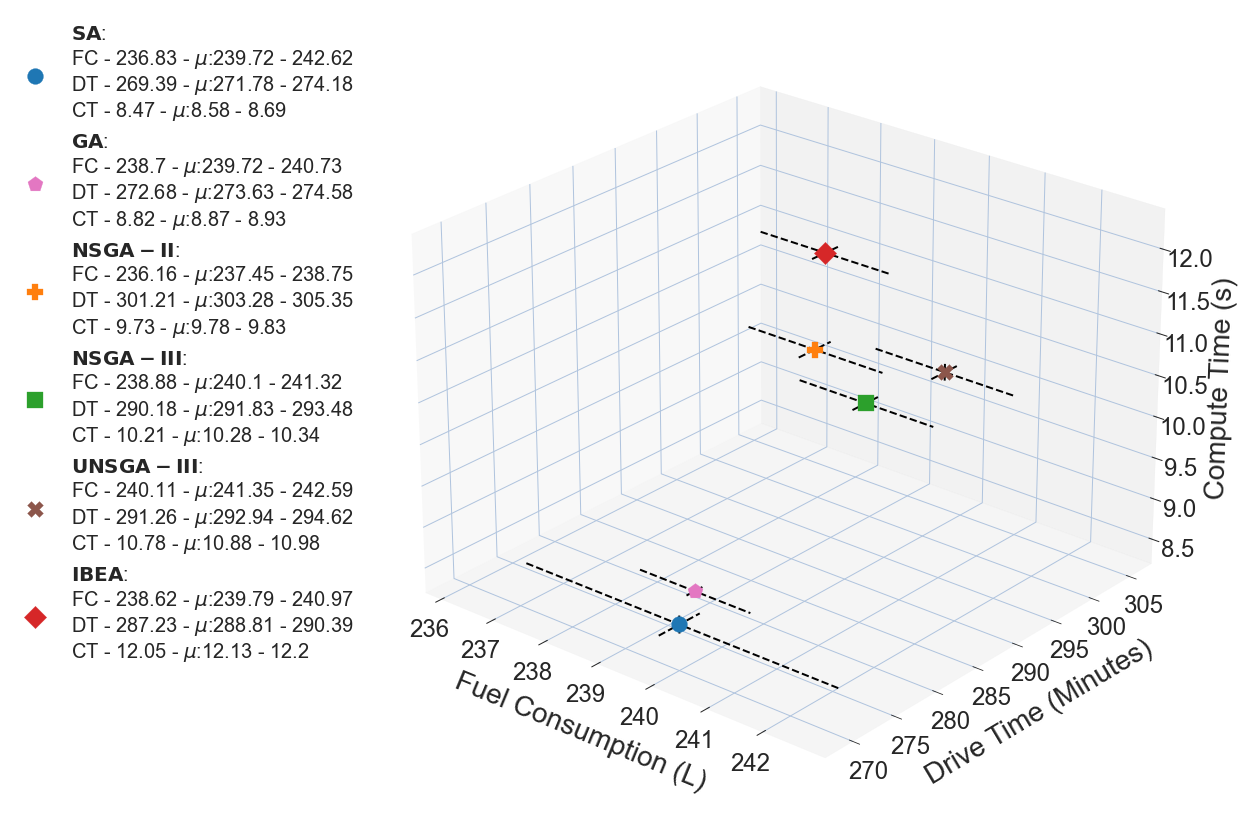

In [158]:
algorithms = [SA_best, GA_best, NSGA2_best, NSGA3_best, UNSGA3_best, IBEA_best]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_3d_minmax(algorithms, labels)
plt.legend(bbox_to_anchor=(0, 1))
ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
ax.set_zlabel("Compute Time (s)", labelpad=16)
ax.view_init(elev=25,azim=-50)
#plt.tight_layout(pad=2)
plt.show()

In [164]:
fig.savefig("{}/confidence_plot_3d_mixed_pop.pdf".format(imgs_path), bbox_inches='tight')